This notebook explores the use of deep learning models to predict the operating mode of a wind turbine based on the two time series from the sensors used in the turbine's operation  

The data are sensor readings and operating modes for 4,000 turbine runs. time_series_1 and
time_series_2 are NumPy arrays of shape (4000,5000). Each observation corresponds to 5,000
records of the turbine over time by one of the two sensors (time_series_1 measures the pitch
angle in each second of operation, and time_series_2 measures the generator torque). y is the
operating mode for each of the 4,000 turbine runs (0 if the turbine is healthy, 1 if the generator
torque is faulty, 2 if the pitch angle is faulty, and 3 if both are faulty). Note that the dataset is
balanced in that each operating mode is represented equally often.

## Recurrent Neural Network

In [1]:
#libraries
import numpy as np
import pickle
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D

In [2]:
#load data
with open('time_series_1.pickle', 'rb') as handle:
    time_series_1 = pickle.load(handle)
with open('time_series_2.pickle', 'rb') as handle:
    time_series_2 = pickle.load(handle)
with open('y.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [3]:
#check data
print(time_series_1.shape)
print(time_series_2.shape)
print(y.shape)

(4000, 5000)
(4000, 5000)
(4000,)


In [4]:
#combine time_serie_1 and time_series_2 into the shape [batch size, time step, number of features]
time_series = np.dstack([time_series_1, time_series_2])
time_series.shape

(4000, 5000, 2)

In [5]:
#convert the y label into dummies
y_dummies = pd.get_dummies(y)
y_dummies = y_dummies.to_numpy()
y_dummies.shape

(4000, 4)

In [6]:
#create training (70%), validation (15%) and test set (15%)
X_train, X_other, y_train, y_others = train_test_split(time_series, y_dummies, train_size=0.7, random_state = 123)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_others, train_size=0.5,random_state = 123 )

#check the shape of the data sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(2800, 5000, 2)
(2800, 4)
(600, 5000, 2)
(600, 4)
(600, 5000, 2)
(600, 4)


### first RNN model - GRU model

In [ ]:
# GRU model with 2 GRU layers 
GRU_model = Sequential([
    GRU(70, return_sequences=True, input_shape=[None, 2]),
    GRU(140),
    Dense(4, activation = "softmax")
])
GRU_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 70)          15540     
                                                                 
 gru_1 (GRU)                 (None, 140)               89040     
                                                                 
 dense (Dense)               (None, 4)                 564       
                                                                 
Total params: 105,144
Trainable params: 105,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit GRU model on our training and validation set
def train_and_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",
                    optimizer=Adam(learning_rate = learning_rate),
                    metrics = ['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                    validation_data = (X_valid,y_valid),
                    batch_size = 20,
                    callbacks = [early_stopping_cb])
    
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
140/140 [==============================] - 177s 1s/step - loss: 1.2788 - accuracy: 0.4114 - val_loss: 1.1714 - val_accuracy: 0.5067
Epoch 2/20
140/140 [==============================] - 174s 1s/step - loss: 1.1333 - accuracy: 0.5086 - val_loss: 1.0546 - val_accuracy: 0.5800
Epoch 3/20
140/140 [==============================] - 174s 1s/step - loss: 0.9609 - accuracy: 0.5789 - val_loss: 0.7855 - val_accuracy: 0.6833
Epoch 4/20
140/140 [==============================] - 175s 1s/step - loss: 0.6789 - accuracy: 0.7150 - val_loss: 0.5813 - val_accuracy: 0.7617
Epoch 5/20
140/140 [==============================] - 175s 1s/step - loss: 0.5623 - accuracy: 0.7746 - val_loss: 0.6104 - val_accuracy: 0.7417
Epoch 6/20
140/140 [==============================] - 174s 1s/step - loss: 0.4545 - accuracy: 0.8154 - val_loss: 0.5285 - val_accuracy: 0.7300
Epoch 7/20
140/140 [==============================] - 174s 1s/step - loss: 0.3908 - accuracy: 0.8361 - val_loss: 0.5185 - val_accuracy: 0.8033

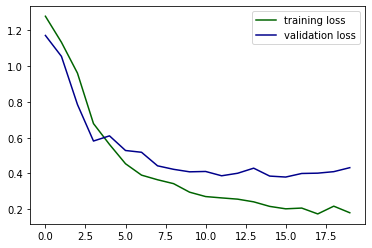

In [ ]:
train_and_plot(GRU_model)

In [ ]:
#evaluate the GRU model on the test set
GRU_valid_accuracy = GRU_model.evaluate(X_valid,y_valid)
GRU_valid_accuracy

19/19 [==============================] - 9s 447ms/step - loss: 0.4325 - accuracy: 0.8450


[0.43248289823532104, 0.8450000286102295]

In [ ]:
#evaluate the GRU model on the test set
GRU_test_accuracy = GRU_model.evaluate(X_test,y_test)
print(GRU_valid_accuracy)

19/19 [==============================] - 8s 437ms/step - loss: 0.4797 - accuracy: 0.8450
[0.43248289823532104, 0.8450000286102295]


### second RNN model - convolutional 1D model

In [100]:
# Convolutional model with 3 conv1D layers and 1 GRU layer
Conv1D_model = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    GRU(128),
    Dense(4, activation = "softmax")
])
Conv1D_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru_2 (GRU)                 (None, 128)               57600     
                                                                 
 dense_19 (Dense)            (None, 4)                 516       
                                                                 
Total params: 61,536
Trainable params: 61,536
Non-trainable params: 0
_________________________________________________________________


In [101]:
def train_and_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",
                    optimizer=Adam(learning_rate = learning_rate),
                    metrics = ['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                    validation_data = (X_valid,y_valid),
                    batch_size = 32,
                    callbacks = [early_stopping_cb])
    
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
88/88 [==============================] - 12s 110ms/step - loss: 1.0417 - accuracy: 0.5593 - val_loss: 0.7411 - val_accuracy: 0.7450
Epoch 2/20
88/88 [==============================] - 9s 102ms/step - loss: 0.5558 - accuracy: 0.8057 - val_loss: 0.4908 - val_accuracy: 0.8250
Epoch 3/20
88/88 [==============================] - 9s 101ms/step - loss: 0.3726 - accuracy: 0.8586 - val_loss: 0.3620 - val_accuracy: 0.8483
Epoch 4/20
88/88 [==============================] - 9s 102ms/step - loss: 0.3038 - accuracy: 0.8743 - val_loss: 0.3392 - val_accuracy: 0.8500
Epoch 5/20
88/88 [==============================] - 9s 101ms/step - loss: 0.2613 - accuracy: 0.8904 - val_loss: 0.3083 - val_accuracy: 0.8700
Epoch 6/20
88/88 [==============================] - 9s 101ms/step - loss: 0.2387 - accuracy: 0.8968 - val_loss: 0.3719 - val_accuracy: 0.8050
Epoch 7/20
88/88 [==============================] - 9s 102ms/step - loss: 0.2256 - accuracy: 0.8971 - val_loss: 0.3071 - val_accuracy: 0.8750
Epoch

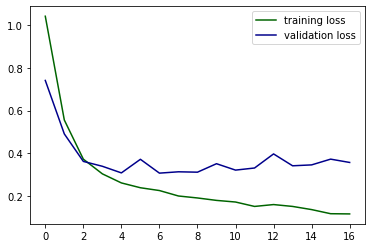

In [102]:
train_and_plot(Conv1D_model)

In [107]:
#evaluate the 1-D convolutional layer model on the validation set
Conv1D_valid_accuracy = Conv1D_model.evaluate(X_valid,y_valid)

19/19 [==============================] - 1s 47ms/step - loss: 0.3071 - accuracy: 0.8750


In [108]:
#evaluate the Conv1D model on the test set
Conv1D_test_accuracy = Conv1D_model.evaluate(X_test,y_test)

19/19 [==============================] - 1s 47ms/step - loss: 0.3227 - accuracy: 0.8767


### third RNN model - LSTM model

In [112]:
#third RNN model
#LSTM model with two LSTM layers
LSTM_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 2]),
    LSTM(50),
    Dense(4, activation = "softmax")
])
LSTM_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31,004
Trainable params: 31,004
Non-trainable params: 0
_________________________________________________________________


In [113]:
def train_and_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",
                    optimizer=Adam(learning_rate = learning_rate),
                    metrics = ['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                    validation_data = (X_valid,y_valid),
                    batch_size = 20,
                    callbacks = [early_stopping_cb])
    
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
140/140 [==============================] - 149s 1s/step - loss: 0.5084 - accuracy: 0.7882 - val_loss: 0.5438 - val_accuracy: 0.7800
Epoch 2/20
140/140 [==============================] - 145s 1s/step - loss: 0.4800 - accuracy: 0.8068 - val_loss: 0.4809 - val_accuracy: 0.8117
Epoch 3/20
140/140 [==============================] - 145s 1s/step - loss: 0.4503 - accuracy: 0.8104 - val_loss: 0.4442 - val_accuracy: 0.8217
Epoch 4/20
140/140 [==============================] - 144s 1s/step - loss: 0.4273 - accuracy: 0.8221 - val_loss: 0.4466 - val_accuracy: 0.8200
Epoch 5/20
140/140 [==============================] - 136s 972ms/step - loss: 0.4453 - accuracy: 0.8196 - val_loss: 0.4220 - val_accuracy: 0.8267
Epoch 6/20
140/140 [==============================] - 145s 1s/step - loss: 0.4108 - accuracy: 0.8293 - val_loss: 0.4963 - val_accuracy: 0.7800
Epoch 7/20
140/140 [==============================] - 145s 1s/step - loss: 0.4083 - accuracy: 0.8329 - val_loss: 0.4235 - val_accuracy: 0.8

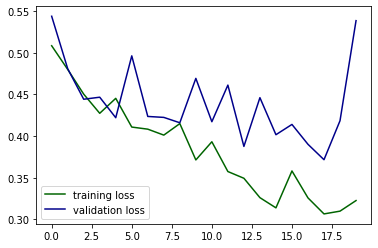

In [138]:
train_and_plot(LSTM_model)

In [139]:
#evaluate the LSTM_model on the validation set
LSTM_valid_accuracy = LSTM_model.evaluate(X_valid,y_valid)

19/19 [==============================] - 10s 434ms/step - loss: 0.5385 - accuracy: 0.7900


In [140]:
#evaluate the LSTM_model on the test set
LSTM_test_accuracy = LSTM_model.evaluate(X_test,y_test)

19/19 [==============================] - 8s 396ms/step - loss: 0.5434 - accuracy: 0.7817


### compare the results of the 3 RNN models

In [141]:
#compare the results
print("The validation set accuracy of GRU model is", round(GRU_valid_accuracy[1], 3))
print("The validation loss in GRU model is", round(GRU_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of LSTM model is", round(LSTM_valid_accuracy[1], 3))
print("The validation loss in LSTM model is", round(LSTM_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of Conv1D model is", round(Conv1D_valid_accuracy[1], 3))
print("The validation loss in Conv1D model is", round(Conv1D_valid_accuracy[0], 3))

The validation set accuracy of GRU model is 0.845
The validation loss in GRU model is 0.432
----------------------
The validation set accuracy of LSTM model is 0.79
The validation loss in LSTM model is 0.539
----------------------
The validation set accuracy of Conv1D model is 0.875
The validation loss in Conv1D model is 0.307


Across the 3 RNN models, the model that consists of both convolutional 1D layer and GRU layer has the highest accuracy on the validation set. Moreover, it has a validation loss that is lower than the other two models, which suggests it can fit the validation set best among the 3 models. This suggests that this RNN model has the best performance in predicting the operating mode of wind turbine from time-series data. 

## Convolution neural network

 Before building CNN model, we need to convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).

In [7]:
# input image dimensions
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # the array shape that we want to convert our data to

# change the type of the current training and testing data
X_train_2 = X_train.astype('float32')
X_test_2 = X_test.astype('float32')
X_valid_2 = X_valid.astype('float32')

# convert the 2 time series into a single array 
if K.image_data_format() == 'channels_first':
    X_train_2 = X_train_2.reshape(X_train_2.shape[0], img_channels, img_rows, img_cols)
    X_test_2 = X_test_2.reshape(X_test_2.shape[0], img_channels, img_rows, img_cols)
    X_valid_2 = X_valid_2.reshape(X_valid_2.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train_2 = X_train_2.reshape(X_train_2.shape[0], img_rows, img_cols, img_channels)
    X_test_2 = X_test_2.reshape(X_test_2.shape[0], img_rows, img_cols, img_channels)
    X_valid_2 = X_valid_2.reshape(X_valid_2.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

In [8]:
#check the shape of the reshaped data
print(X_train_2[0].shape)
print(X_test_2[0].shape)
print(X_valid_2[0].shape)

(100, 100, 1)
(100, 100, 1)
(100, 100, 1)


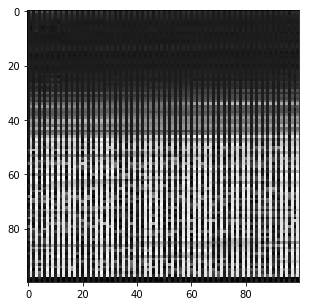

In [9]:
# plot the gray-scale image
X_train_3  = X_train_2[0]
plt.figure(figsize=(5, 5))
plt.imshow(X_train_3[:,:,-1].astype(int), cmap="gray")
plt.show()

# First CNN model

In [44]:
#build CNN model: 3 Convolutional layers, 1 dropout layer, 1 max pooling and 1 FCNN layer
model_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                      

In [45]:
#fit the CNN model on our training and validation data
def train_and_plot2(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)
    log = model.fit(X_train_2, y_train, 
                    validation_data = (X_valid_2,y_valid),
                    epochs=epochs, batch_size = 5)
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    return model

Epoch 1/20
560/560 [==============================] - 7s 7ms/step - loss: 3.3472 - accuracy: 0.5000 - val_loss: 0.4134 - val_accuracy: 0.8667
Epoch 2/20
560/560 [==============================] - 4s 6ms/step - loss: 0.6711 - accuracy: 0.8061 - val_loss: 0.5718 - val_accuracy: 0.8983
Epoch 3/20
560/560 [==============================] - 4s 6ms/step - loss: 0.4548 - accuracy: 0.8361 - val_loss: 0.3269 - val_accuracy: 0.8267
Epoch 4/20
560/560 [==============================] - 3s 6ms/step - loss: 0.3502 - accuracy: 0.8654 - val_loss: 0.2605 - val_accuracy: 0.9000
Epoch 5/20
560/560 [==============================] - 3s 6ms/step - loss: 0.3071 - accuracy: 0.8714 - val_loss: 0.2959 - val_accuracy: 0.8967
Epoch 6/20
560/560 [==============================] - 3s 6ms/step - loss: 0.2803 - accuracy: 0.8854 - val_loss: 0.2679 - val_accuracy: 0.8667
Epoch 7/20
560/560 [==============================] - 3s 6ms/step - loss: 0.2824 - accuracy: 0.8800 - val_loss: 0.2987 - val_accuracy: 0.8967
Epoch 

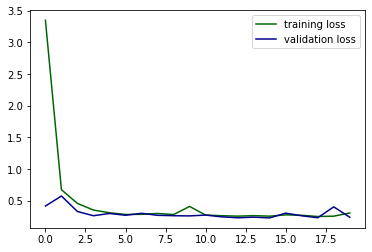

In [46]:
train_and_plot2(model_cnn)

In [94]:
#evaluate the model on the validation set
model_cnn_validation = model_cnn.evaluate(X_valid_2, y_valid)

19/19 [==============================] - 0s 6ms/step - loss: 0.2363 - accuracy: 0.8900


In [95]:
#evaluate the model on the validation set
model_cnn_test = model_cnn.evaluate(X_test_2, y_test)

19/19 [==============================] - 0s 6ms/step - loss: 0.3092 - accuracy: 0.8983


5. Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

### Second CNN model - adding more convolutional layers

In [129]:
# CNN model with 5 Convolutional layers, 1 dropout layer, 1 max pooling and 1 FCNN layer
model_cnn2 = Sequential([
    Conv2D(128, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(64, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same', activation='relu'),
    Conv2D(8, kernel_size=(3, 3),strides=(2,2),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_cnn2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_399 (Conv2D)         (None, 50, 50, 128)       1280      
                                                                 
 conv2d_400 (Conv2D)         (None, 25, 25, 64)        73792     
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_401 (Conv2D)         (None, 13, 13, 32)        18464     
                                                                 
 conv2d_402 (Conv2D)         (None, 7, 7, 16)          4624      
                                                                 
 conv2d_403 (Conv2D)         (None, 4, 4, 8)           1160      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 1, 1, 8)        

In [57]:
#fit the CNN model with 5 convolutional layer on our training and validation data
def train_and_plot2(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)
    log = model.fit(X_train_2, y_train,
                    validation_data = (X_valid_2,y_valid),
                    epochs=epochs, batch_size = 20)
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
140/140 [==============================] - 3s 19ms/step - loss: 2.1330 - accuracy: 0.2814 - val_loss: 1.3197 - val_accuracy: 0.3383
Epoch 2/20
140/140 [==============================] - 2s 17ms/step - loss: 1.2430 - accuracy: 0.4350 - val_loss: 0.9388 - val_accuracy: 0.6467
Epoch 3/20
140/140 [==============================] - 2s 17ms/step - loss: 0.7363 - accuracy: 0.6975 - val_loss: 0.4999 - val_accuracy: 0.7867
Epoch 4/20
140/140 [==============================] - 3s 18ms/step - loss: 0.5060 - accuracy: 0.8075 - val_loss: 0.3886 - val_accuracy: 0.8567
Epoch 5/20
140/140 [==============================] - 3s 19ms/step - loss: 0.4090 - accuracy: 0.8439 - val_loss: 0.3930 - val_accuracy: 0.8817
Epoch 6/20
140/140 [==============================] - 3s 18ms/step - loss: 0.3550 - accuracy: 0.8629 - val_loss: 0.3329 - val_accuracy: 0.8933
Epoch 7/20
140/140 [==============================] - 3s 19ms/step - loss: 0.3123 - accuracy: 0.8793 - val_loss: 0.3407 - val_accuracy: 0.8833

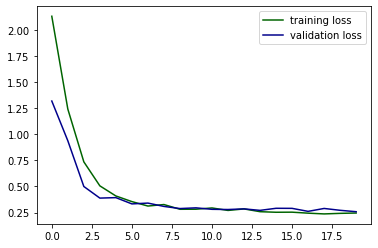

In [58]:
train_and_plot2(model_cnn2)

In [96]:
#evaluate the model on the validation set
model_cnn2_validation = model_cnn2.evaluate(X_valid_2, y_valid)

19/19 [==============================] - 0s 13ms/step - loss: 0.2580 - accuracy: 0.8983


In [97]:
#evaluate the model on the test set
model_cnn2_test = model_cnn2.evaluate(X_test_2, y_test)

19/19 [==============================] - 0s 13ms/step - loss: 0.3013 - accuracy: 0.8933


### third CNN model - using pretrained MobileNet architecture

In [61]:
# CNN model using pre-trained MobileNet model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from pandas._libs.lib import fast_unique_multiple_list_gen

# pre-process the training and test data for MobileNet
x_preprocess_train = preprocess_input(X_train_2.copy())
x_preprocess_test = preprocess_input(X_test_2.copy())
x_preprocess_valid = preprocess_input(X_valid_2.copy())
print(x_preprocess_train.shape, x_preprocess_test.shape,x_preprocess_valid.shape )

(2800, 100, 100, 1) (600, 100, 100, 1) (600, 100, 100, 1)


In [90]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (100,100,3))
mobilenet.trainable = False

# Un-Freeze the first 60 layers in the base model 
for layer in mobilenet.layers[:60]:
    layer.trainable = True

model_mobilenet = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
model_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model_mobilenet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_398 (Conv2D)         (None, 100, 100, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 64)                65600     
                                                                 
 dense_18 (Dense)            (None, 4)                 260       
                                                                 
Total params: 3,294,754
Trainable params: 65,890
Non-

Epoch 1/30
100/100 [==============================] - 7s 54ms/step - loss: 1.2799 - accuracy: 0.4575 - val_loss: 1.7766 - val_accuracy: 0.2567
Epoch 2/30
100/100 [==============================] - 5s 46ms/step - loss: 0.8023 - accuracy: 0.6946 - val_loss: 1.4706 - val_accuracy: 0.3133
Epoch 3/30
100/100 [==============================] - 5s 46ms/step - loss: 0.6058 - accuracy: 0.7914 - val_loss: 0.8242 - val_accuracy: 0.6250
Epoch 4/30
100/100 [==============================] - 5s 46ms/step - loss: 0.4892 - accuracy: 0.8350 - val_loss: 0.5302 - val_accuracy: 0.8167
Epoch 5/30
100/100 [==============================] - 5s 47ms/step - loss: 0.4157 - accuracy: 0.8611 - val_loss: 0.4571 - val_accuracy: 0.8383
Epoch 6/30
100/100 [==============================] - 5s 46ms/step - loss: 0.3691 - accuracy: 0.8757 - val_loss: 0.4231 - val_accuracy: 0.8650
Epoch 7/30
100/100 [==============================] - 5s 46ms/step - loss: 0.3390 - accuracy: 0.8846 - val_loss: 0.3966 - val_accuracy: 0.8583

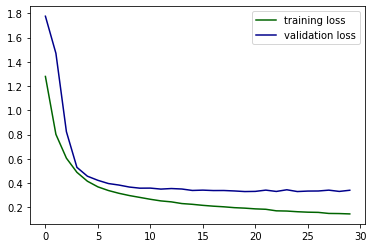

In [91]:
#fit the mobilenet model on our training and validation data
log = model_mobilenet.fit(x_preprocess_train, y_train,
                    validation_data = (x_preprocess_valid,y_valid),
                    batch_size=28,
                    epochs=30)

plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [92]:
#evaluate the model on the validation set
model_mobilenet_validation = model_mobilenet.evaluate(x_preprocess_valid, y_valid)

19/19 [==============================] - 1s 26ms/step - loss: 0.3412 - accuracy: 0.8667


In [93]:
#evaluate the model on the test set
model_mobilenet_test = model_mobilenet.evaluate(x_preprocess_test, y_test)

19/19 [==============================] - 0s 22ms/step - loss: 0.3356 - accuracy: 0.8683


### forth CNN model - using pretrained InceptionV3 architecture

In [86]:
# CNN model with pretrained InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape = (100,100,3))
InceptionV3.trainable = False

model_InceptionV3 = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    InceptionV3,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
model_InceptionV3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_InceptionV3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_397 (Conv2D)         (None, 100, 100, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 64)                131136    
                                                                 
 dense_16 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,934,210
Trainable params: 131,426
Non-trainable params: 21,802,784
___________________________________

Epoch 1/30
100/100 [==============================] - 23s 174ms/step - loss: 1.0807 - accuracy: 0.5332 - val_loss: 0.8653 - val_accuracy: 0.6633
Epoch 2/30
100/100 [==============================] - 16s 156ms/step - loss: 0.7039 - accuracy: 0.7393 - val_loss: 0.6374 - val_accuracy: 0.7633
Epoch 3/30
100/100 [==============================] - 16s 157ms/step - loss: 0.5779 - accuracy: 0.7854 - val_loss: 0.5295 - val_accuracy: 0.8300
Epoch 4/30
100/100 [==============================] - 16s 155ms/step - loss: 0.4813 - accuracy: 0.8289 - val_loss: 0.4789 - val_accuracy: 0.8283
Epoch 5/30
100/100 [==============================] - 16s 156ms/step - loss: 0.4353 - accuracy: 0.8421 - val_loss: 0.4353 - val_accuracy: 0.8200
Epoch 6/30
100/100 [==============================] - 16s 157ms/step - loss: 0.4090 - accuracy: 0.8479 - val_loss: 0.3801 - val_accuracy: 0.8483
Epoch 7/30
100/100 [==============================] - 16s 156ms/step - loss: 0.3622 - accuracy: 0.8596 - val_loss: 0.4151 - val_ac

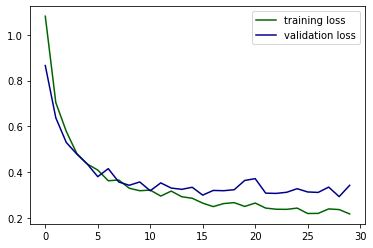

In [87]:
#fit the InceptionV3 model on our training and validation data
log = model_InceptionV3.fit(x_preprocess_train, y_train,
                      validation_data = (x_preprocess_valid,y_valid),
                      batch_size=28,
                      epochs=30)

plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [88]:
#evaluate the model on the validation set
model_InceptionV3_validation = model_InceptionV3.evaluate(x_preprocess_valid, y_valid)

19/19 [==============================] - 1s 61ms/step - loss: 0.3423 - accuracy: 0.8617


In [89]:
#evaluate the model on the test set
model_InceptionV3_test = model_InceptionV3.evaluate(x_preprocess_test, y_test)

19/19 [==============================] - 1s 57ms/step - loss: 0.4008 - accuracy: 0.8600


### compare the results

In [111]:
#comapare all CNN models
print("The validation set accuracy of CNN model with 3 Convolutional layers is:", round(model_cnn_validation[1], 3))
print("The validation loss in CNN model with 3 Convolutional layers is:", round(model_cnn_validation[0], 3))
print("---------------------")
print("The validation set accuracy of CNN model with 5 Convolutional layers is:", round(model_cnn2_validation[1], 3))
print("The validation loss in CNN model with 5 Convolutional layers is:", round(model_cnn2_validation[0], 3))
print("---------------------")
print("The validation set accuracy of mobilenet model is:", round(model_mobilenet_validation[1], 3))
print("The validation loss in mobilenet model is:", round(model_mobilenet_validation[0], 3))
print("---------------------")
print("The validation set accuracy of InceptionV3 model is;", round(model_InceptionV3_validation[1], 3))
print("The validation loss in InceptionV3 model is;", round(model_InceptionV3_validation[0], 3))

The validation set accuracy of CNN model with 3 Convolutional layers is: 0.89
The validation loss in CNN model with 3 Convolutional layers is: 0.236
---------------------
The validation set accuracy of CNN model with 4 Convolutional layers is: 0.898
The validation loss in CNN model with 4 Convolutional layers is: 0.258
---------------------
The validation set accuracy of mobilenet model is: 0.867
The validation loss in mobilenet model is: 0.341
---------------------
The validation set accuracy of InceptionV3 model is; 0.862
The validation loss in InceptionV3 model is; 0.342


Overall, the model with 5 convolution layers, 1 dropout layer, 1 max pooling and 1 FCNN layer has the highest accuracy on predicting the validation set. It also has a lower validation loss when compared to the models that used pretrained CNN architecture. Hence, this model has a better performance in predicting the operating mode of a wind turbine from a matrix data. 

## Best model

This section will compare all the models that I have implemented (both CNN and RNN).

In [118]:
#compare the results across all models
print("RNN models: ")
print(" ")
print("The validation set accuracy of GRU model is", round(GRU_valid_accuracy[1], 3))
print("The validation loss in GRU model is", round(GRU_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of LSTM model is", round(LSTM_valid_accuracy[1], 3))
print("The validation loss in LSTM model is", round(LSTM_valid_accuracy[0], 3))
print("----------------------")
print("The validation set accuracy of Conv1D model is", round(Conv1D_valid_accuracy[1], 3))
print("The validation loss in Conv1D model is", round(Conv1D_valid_accuracy[0], 3))
print(" ")
print("CNN models: ")
print(" ")
print("The validation set accuracy of CNN model with 3 Convolutional layers is:", round(model_cnn_validation[1], 3))
print("The validation loss in CNN model with 3 Convolutional layers is:", round(model_cnn_validation[0], 3))
print("---------------------")
print("The validation set accuracy of CNN model with 5 Convolutional layers is:", round(model_cnn2_validation[1], 3))
print("The validation loss in CNN model with 5 Convolutional layers is:", round(model_cnn2_validation[0], 3))
print("---------------------")
print("The validation set accuracy of mobilenet model is:", round(model_mobilenet_validation[1], 3))
print("The validation loss in mobilenet model is:", round(model_mobilenet_validation[0], 3))
print("---------------------")
print("The validation set accuracy of InceptionV3 model is;", round(model_InceptionV3_validation[1], 3))
print("The validation loss in InceptionV3 model is;", round(model_InceptionV3_validation[0], 3))


RNN models: 
 
The validation set accuracy of GRU model is 0.845
The validation loss in GRU model is 0.432
----------------------
The validation set accuracy of LSTM model is 0.798
The validation loss in LSTM model is 0.506
----------------------
The validation set accuracy of Conv1D model is 0.875
The validation loss in Conv1D model is 0.307
 
CNN models: 
 
The validation set accuracy of CNN model with 3 Convolutional layers is: 0.89
The validation loss in CNN model with 3 Convolutional layers is: 0.236
---------------------
The validation set accuracy of CNN model with 5 Convolutional layers is: 0.898
The validation loss in CNN model with 5 Convolutional layers is: 0.258
---------------------
The validation set accuracy of mobilenet model is: 0.867
The validation loss in mobilenet model is: 0.341
---------------------
The validation set accuracy of InceptionV3 model is; 0.862
The validation loss in InceptionV3 model is; 0.342


Based on the exploration on RNN and CNN, the CNN models with convolutional layers, 1 dropout layer, 1 max pooling and 1 FCNN layer have the highest accuracies and lowest validation losses. This means that these CNN models have the best performance in predicting outcomes accuractely and can fit the validation set best. In particular, the CNN model with 5 convolutional layers (with increased number of kernels in the first layer) has a moderately higher accuracy than the CNN model with 3 convolutional layers, while other layers are kept constant. As discussed in question 2, CNN models can have more accurate prediction on than RNN models by noise reduction in the time-series data during the learning process, and this is proven by the results in this study. Adding more convolutional layers and kernels mean including more filters to sharpen the features of the input data, which in turns exclude more irrelevant features as well as noise during the learning process. Hence, the CNN model with 5 convolutional layers has a more reliable and accurate prediction output. This model is thus chosen as the best model in classifying the operating mode of a wind turbine among all the models.

# Run the best model

In [130]:
#combine training and validation set to allow the final training set to contain 85% of original data
X_train_valid = np.concatenate((X_train, X_valid))
y_train_valid = np.concatenate((y_train, y_valid))

print(X_train_valid.shape)
print(y_train_valid.shape)

(3400, 5000, 2)
(3400, 4)


In [131]:
# input image dimensions
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # the array shape that we want to convert our data to

# change the type of the current training and testing data
X_train_valid = X_train_valid.astype('float32')

# convert the X_train_valid into a single array 
if K.image_data_format() == 'channels_first':
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train_valid= X_train_valid.reshape(X_train_valid.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print(X_train_valid[0].shape)

(100, 100, 1)


In [133]:
X_train_valid.shape

(3400, 100, 100, 1)

In [134]:
# run this updated training set on the CNN model with 5 convolutional layers, 1 dropout layer, 1 max pooling and 1 FCNN layer
def train_and_plot_final(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)
    log = model.fit(X_train_valid, y_train_valid,
                    epochs=epochs, batch_size = 20)
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.legend()
    ax = plt.gca()
    plt.show()

    return model

Epoch 1/20
170/170 [==============================] - 3s 16ms/step - loss: 1.8795 - accuracy: 0.2650
Epoch 2/20
170/170 [==============================] - 3s 15ms/step - loss: 1.4005 - accuracy: 0.2629
Epoch 3/20
170/170 [==============================] - 3s 15ms/step - loss: 1.0596 - accuracy: 0.5362
Epoch 4/20
170/170 [==============================] - 3s 15ms/step - loss: 0.4128 - accuracy: 0.8491
Epoch 5/20
170/170 [==============================] - 3s 15ms/step - loss: 0.3189 - accuracy: 0.8785
Epoch 6/20
170/170 [==============================] - 3s 15ms/step - loss: 0.2852 - accuracy: 0.8797
Epoch 7/20
170/170 [==============================] - 3s 15ms/step - loss: 0.2874 - accuracy: 0.8797
Epoch 8/20
170/170 [==============================] - 3s 15ms/step - loss: 0.2578 - accuracy: 0.8853
Epoch 9/20
170/170 [==============================] - 3s 15ms/step - loss: 0.2500 - accuracy: 0.8879
Epoch 10/20
170/170 [==============================] - 3s 15ms/step - loss: 0.2498 - accura

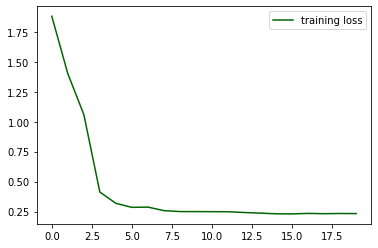

In [135]:
train_and_plot_final(model_cnn2)

In [136]:
#evaluate the model on the test set
model_cnn2.evaluate(X_test_2, y_test)

19/19 [==============================] - 0s 12ms/step - loss: 0.2830 - accuracy: 0.8967


[0.2829788625240326, 0.8966666460037231]

In [137]:
model_cnn2.save("model_final.h5")